In [13]:
%matplotlib inline
import qiskit
import time
from qiskit import IBMQ
from qiskit import Aer

# Authenticate an account and add for use during this session. Replace string
# argument with your private token.
IBMQ.enable_account('407e9bae3b7dcde32639a7dcedf05ae6d7a0bed5c1a328e149afd88e5a6584d3776bfa94fdbcad4de27402abf2ed41b183ba3e6877fd64b80917cc06c4e820ae','https://api.quantum-computing.ibm.com/api/Hubs/ibm-q/Groups/open/Projects/main')# To store your credentials locally you can run:


In [14]:
print(IBMQ.backends())
print(Aer.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmqx4') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmqx2') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(ibm-q, open, main)>]
[<QasmSimulator('qasm_simulator') from AerProvider()>, <StatevectorSimulator('statevector_simulator') from AerProvider()>, <UnitarySimulator('unitary_simulator') from AerProvider()>]


# Showing errors introduced by repeated application of I gate, IBM QX Device

In [15]:
import time
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit import compile,execute

def apply_identity_gate(qubit_val,apply_times=10,noisy=True,simulator=True):
    shots=1000
    qr = qiskit.QuantumRegister(1)
    cr = qiskit.ClassicalRegister(1)
    qc = qiskit.QuantumCircuit(qr, cr)
    if qubit_val not in [0,1]:
        raise Exception("initial qubit must be either 0 or 1")
    if qubit_val==1:
        # Setting q0=|"1">
        qc.x(qr[0])

    # Applying the identity gate 10 times. 
    for i in range(apply_times):
        qc.iden(qr[0])

    # Measuring the result. If our hardware was perfect, it should always yield the same value as qubit_val
    qc.measure(qr[0],cr[0])

    if simulator:
        backend = Aer.get_backend('qasm_simulator') # Local simulator
        if noisy:
            device = IBMQ.get_backend('ibmqx4')
            properties = device.properties()
            coupling_map = device.configuration().coupling_map
            noise_model = noise.device.basic_device_noise_model(properties)
            basis_gates = noise_model.basis_gates
            exp_job = execute(qc, backend,
                                coupling_map=coupling_map,
                                noise_model=noise_model,
                                basis_gates=basis_gates)
        else:
            exp_job = execute(qc,backend,shots=shots)
    else:
        if noisy:
    # Preparing to run
            backend = IBMQ.backends(name='ibmqx4')[0] # remote hardware
            exp_job = execute(qc,backend,shots=shots)
        else:
            raise Exception("Hardware is always noisy, to use hardware keep noise=True")

    exp_result = exp_job.result()
    final=exp_result.get_counts(qc)
    print(final)
    plot_histogram(final)
    
apply_identity_gate(1,noisy=True,simulator=False)


{'1': 808, '0': 192}


# Bit flip code

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmqx4') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmqx2') from IBMQ(ibm-q, open, main)>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(ibm-q, open, main)>]
{'01 000': 14, '00 101': 42, '10 101': 17, '10 100': 5, '11 110': 34, '01 100': 16, '11 011': 16, '00 110': 98, '10 001': 16, '11 010': 10, '01 111': 62, '10 111': 16, '00 010': 45, '11 100': 17, '11 101': 20, '10 000': 8, '01 010': 20, '01 110': 43, '11 000': 10, '00 011': 103, '00 000': 27, '00 001': 31, '01 001': 22, '00 111': 156, '01 011': 43, '11 001': 14, '10 011': 12, '10 010': 9, '11 111': 20, '01 101': 17, '10 110': 8, '00 100': 29}


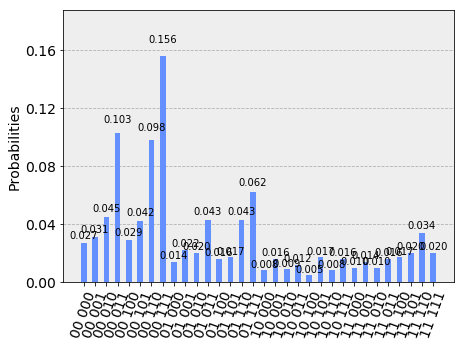

In [18]:
# Simulating a simple error
import random
from qiskit import QuantumCircuit
shots=1000
qasm_string="""
include "qelib1.inc";
qreg qr[5];
creg result[3];
//// these will serve as the bits that will help us figure out if we have errors
creg er[2];

//// First qubit is |"0"> unless you uncomment the following line 
//// to initialize to |"1">:
//x qr[0];

////See figure 3 of https://arxiv.org/pdf/0905.2794.pdf for circuit
////Desire: If first qubit was |"0"> we now have |"000">. If first qubit was |"1"> we now have |"111">
////To reach this: entangle the original qubit across 3 qubits:
cx qr[0], qr[1];
cx qr[1], qr[2];


//// Modeling an error by uncommenting just ONE of the following suggestions:
//// (if you uncomment more than 1 the error correction is ambiguous)
//// Uncomment the following to model a single bit flip error by flipping 0th qubit:
// x qr[0];
//// If our initial state was |"0"> we now have |"100"> because of error on 0th qubit
//// if our initial state was |"1"> we now have |"011"> because of error on 0th qubit

// Uncomment the following to model a single bit flip error by flipping 1th qubit:
//x qr[1];
//// If our initial state was |"0"> we now have |"010"> because of error on 1th qubit
//// if our initial state was |"1"> we now have |"101"> because of error on 1th qubit

// Uncomment the following to model a single bit flip error by flipping 2th qubit:
//x qr[2];
//// If our initial state was |"0"> we now have |"001"> because of error on 2th qubit
//// if our initial state was |"1"> we now have |"110"> because of error on 2th qubit


//// Now: our goal is to recover the original state. 
///// To do this we entangle with a few extra qubits (3th and 4th qubit):
cx qr[0],qr[3];
cx qr[1],qr[3];
cx qr[0],qr[4];
cx qr[2],qr[4];

//// Now we can make measurements of 3th and 4th qubit to get information about our 3 qubit without disturbing it
measure qr[3]->er[1];
measure qr[4]->er[0];

////
//// See table 1 of https://arxiv.org/pdf/0905.2794.pdf for how to correct
////case: 11 (3 in decimal), 0th qubit has error so flip back
//if(er==3)
x qr[0];

////case: 10 (2 in decimal), 1th qubit has error so flip back
//if(er==2)
x qr[1];

////case: 01 (1 in decimal), 2th qubit has error so flip back
//if(er==1)
x qr[2];
//// 00 do nothing, there wer no errors

measure qr[0]->result[0];
measure qr[1]->result[1];
measure qr[2]->result[2];

"""
print(IBMQ.backends())
backend = IBMQ.get_backend('ibmqx4')
qc = QuantumCircuit.from_qasm_str(qasm_string)
exp_job = execute(qc,backend,shots=shots)
exp_result = exp_job.result()
final=exp_result.get_counts(qc)
print(final)
plot_histogram(final)

In [19]:
# Simulating a simple error
import random
from qiskit import QuantumCircuit
shots=1000
qasm_string="""
include "qelib1.inc";
qreg qr[5];
creg result[3];
//// these will serve as the bits that will help us figure out if we have errors
creg er[2];

//// First qubit is |"0"> unless you uncomment the following line 
//// to initialize to |"1">:
//x qr[0];

////See figure 3 of https://arxiv.org/pdf/0905.2794.pdf for circuit
////Desire: If first qubit was |"0"> we now have |"000">. If first qubit was |"1"> we now have |"111">
////To reach this: entangle the original qubit across 3 qubits:
cx qr[0], qr[1];
cx qr[1], qr[2];

h qr[0];
h qr[1];
h qr[2];

//// Modeling an error by uncommenting just ONE of the following suggestions:
//// (if you uncomment more than 1 the error correction is ambiguous)
//// Uncomment the following to model a single phase flip error by flipping 0th qubit:
// z qr[0];
//// If our initial state was |"0"> we now have |"100"> because of error on 0th qubit
//// if our initial state was |"1"> we now have |"011"> because of error on 0th qubit

// Uncomment the following to model a single phase flip error by flipping 1th qubit:
//z qr[1];
//// If our initial state was |"0"> we now have |"010"> because of error on 1th qubit
//// if our initial state was |"1"> we now have |"101"> because of error on 1th qubit

// Uncomment the following to model a single phas flip error by flipping 2th qubit:
//z qr[2];
//// If our initial state was |"0"> we now have |"001"> because of error on 2th qubit
//// if our initial state was |"1"> we now have |"110"> because of error on 2th qubit
h qr[0];
h qr[1];
h qr[2];


//// Now: our goal is to recover the original state. 
///// To do this we entangle with a few extra qubits (3th and 4th qubit):
cx qr[0],qr[3];
cx qr[1],qr[3];
cx qr[0],qr[4];
cx qr[2],qr[4];

//// Now we can make measurements of 3th and 4th qubit to get information about our 3 qubit without disturbing it
measure qr[3]->er[1];
measure qr[4]->er[0];

////
//// See table 1 of https://arxiv.org/pdf/0905.2794.pdf for how to correct
////case: 11 (3 in decimal), 0th qubit has error so flip back
if(er==3)
z qr[0];

////case: 10 (2 in decimal), 1th qubit has error so flip back
if(er==2)
z qr[1];

////case: 01 (1 in decimal), 2th qubit has error so flip back
if(er==1)
z qr[2];
//// 00 do nothing, there were no errors

measure qr[0]->result[0];
measure qr[1]->result[1];
measure qr[2]->result[2];

"""

backend = Aer.get_backend('qasm_simulator')
qc = QuantumCircuit.from_qasm_str(qasm_string)
exp_job = execute(qc,backend,shots=shots)
exp_result = exp_job.result()
final=exp_result.get_counts(qc)
print(final)
plot_histogram(final)

TranspilerError: 'internal error'